In [1]:
from IPython import get_ipython
get_ipython().magic('reset -sf') 

import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
from imblearn.over_sampling import SMOTE       #over sampling of minority class in imbalanced data
from imblearn.combine import SMOTEENN          #over sampling of minority class in imbalanced data
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold,GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import RFE,RFECV
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score,average_precision_score,precision_recall_curve,precision_score

import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_columns', 100)

/Users/venkatasravankanukolanu/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/venkatasravankanukolanu/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# read the input files and look at the top few lines #
data_path = "/Users/venkatasravankanukolanu/Documents/Data Files/credit_fraud/"
data_df= pd.read_csv(data_path+"creditcard.csv")
data_df.head(2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0


In [3]:
data_df['std_amount'] = StandardScaler().fit_transform(data_df['Amount'].reshape(-1, 1))
data_df= data_df.drop(['Time','Amount'],axis=1)
data_df.head(2)

/Users/venkatasravankanukolanu/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,std_amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475


Since V1 through V28 are principal compotents from PCA on the actual data, V1 through V28 are independent. This eliminates the problem of multicolinearity in the data. 

Since the data set meets the assumptions of Binary Logistic Regression Model i.e.

1. The dependent variable is binary.
2. The factor level 1 of the dependent variable represents the desired outcome i.e. fraud.
3. The independent variables are independent of each other since they are principal components.

In [4]:
response='Class'
predictors=data_df.columns[data_df.columns != 'Class']

#### Split the data as test and train

In [5]:
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(data_df[predictors], data_df[response], test_size=0.1, random_state=2,stratify=data_df[response])

### Variable Importance

#### Recursive Feature Elimination through Cross-Validation

In [6]:
# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring is proportional to the number of correct classifications
def rfe_cv(x_train_data,y_train_data):
    rfecv = RFECV(estimator=LogisticRegression(), step=1, cv=5, scoring='average_precision')
    rfecv.fit(x_train_data, y_train_data)
    
    selected_features=list(x_train_data.columns[rfecv.support_])
    
    print("Optimal number of features: %d" % rfecv.n_features_)
    print('Selected features: %s' % selected_features)

    # Plot number of features VS. cross-validation scores
    plt.figure(figsize=(10,6))
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (Average Precision)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()
    
    return(selected_features)

Optimal number of features: 24
Selected features: ['V1', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V13', 'V14', 'V15', 'V16', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'std_amount']


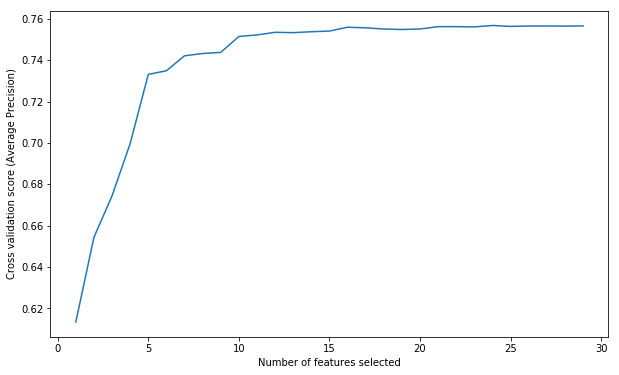

In [7]:
preds=rfe_cv(df_train_x, df_train_y)

### Baseline: Logistic Regression with Validation Set Approach

Training a logistic regression and testing it on a validation set.

In [8]:
def logit(x,y,c,RecallMin=None):
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=2,stratify=y)

    # check classification scores of logistic regression
    logreg = LogisticRegression(penalty = 'l1', C =c, class_weight ='balanced',random_state = 2)
    logreg.fit(X_train, y_train)

    y_pred = logreg.predict(X_test)
    y_pred_proba = logreg.predict_proba(X_test)[:, 1]
    area_prc = average_precision_score(y_test, y_pred_proba)
    print('Logit Model Results:')
    print(logreg.__class__.__name__+" Area under PR-Curve is %2.3f" % area_prc)

    precision, recall, thr = precision_recall_curve(y_test, y_pred_proba,pos_label =1)
    
    if RecallMin:
        print "Plot to maximize Precision with a minimum Recall of ",RecallMin
        ind=np.argmax(precision[recall>RecallMin])
        
        plt.figure(figsize=(10,6))
        plt.plot(recall, precision, color='coral', label='2-class Precision-Recall curve: (area = %0.3f)' % area_prc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot([0,recall[ind]], [precision[ind],precision[ind]], 'k--', color='blue')
        plt.plot([recall[ind],recall[ind]], [0,precision[ind]], 'k--', color='blue')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall', fontsize=14)
        plt.ylabel('Precision', fontsize=14)
        plt.title('Precision-Recall Curve')
        plt.legend(loc="lower right")
        plt.show()
       
        print("Using a threshold of %.3f " % thr[ind] + "guarantees a precision of %.3f " % precision[ind] +  
                  "and a recall of %.3f" % recall[ind])
    else:
        print
        print('Plot to maximize both Precision and Recall')
        area, thr = ((precision)*(recall)), thr
        idx= np.argmax(area)

        plt.figure(figsize=(10,6))
        plt.plot(recall, precision, color='coral', label='2-class Precision-Recall curve: (area = %0.3f)' % area_prc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot([0,recall[idx]], [precision[idx],precision[idx]], 'k--', color='blue')
        plt.plot([recall[idx],recall[idx]], [0,precision[idx]], 'k--', color='blue')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall', fontsize=14)
        plt.ylabel('Precision', fontsize=14)
        plt.title('Precision-Recall Curve')
        plt.legend(loc="lower right")
        plt.show()

        print("Using a threshold of %.3f " % thr[idx] + "guarantees a precision of %.3f " % precision[idx] +  
                  "and a recall of %.3f" % recall[idx])


Logit Model Results:
LogisticRegression Area under PR-Curve is 0.530
Plot to maximize Precision with a minimum Recall of  0.8


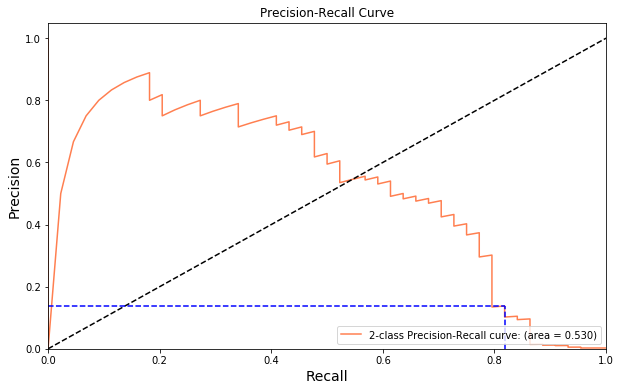

Using a threshold of 0.787 guarantees a precision of 0.138 and a recall of 0.818


In [9]:
logit(df_train_x[preds],df_train_y,1,0.8)

Logit Model Results:
LogisticRegression Area under PR-Curve is 0.530

Plot to maximize both Precision and Recall


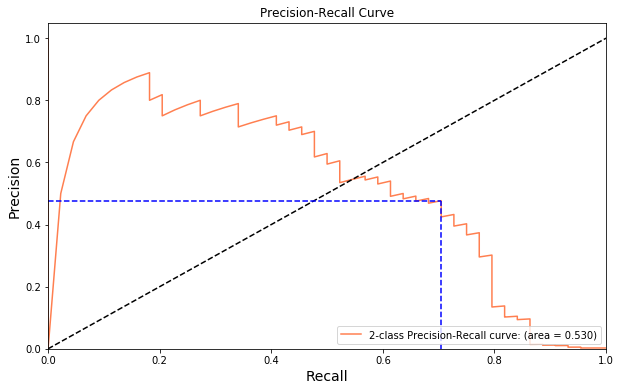

Using a threshold of 0.988 guarantees a precision of 0.477 and a recall of 0.705


In [10]:
logit(df_train_x[preds],df_train_y,1)

Using a threshold of 0.988 gives a recall of 70.5% and precision of 47.7% i.e. the model correctly predicts fraud transactions 70.5% of the time and 47.7% of those predicted as fraud are actually fraud transactions. But since the cost of missing fraud transactions is more expensive to Banking businesses than the cost of investigating non-fraudulent transactions, we need to give more importance to recall than precision. <br>
Using a threshold of 0.787 gives a recall of 81.8% and precision of 13.8% i.e. the model correctly predicts fraud transactions 81.8% of the time and 13.8% of those predicted as fraud are actually fraud transactions

### Model evaluation with 5-Fold Cross Validation

In [11]:
def logitcv(X_train, X_test, y_train, y_test,c):

    logreg = LogisticRegression(penalty = 'l1', C =c, class_weight ='balanced',random_state = 2)
    logreg.fit(X_train, y_train)

    y_pred = logreg.predict(X_test)
    y_pred_proba = logreg.predict_proba(X_test)[:, 1]
    
    precision, recall, thr = precision_recall_curve(y_test, y_pred_proba,pos_label =1)
    
    area_prc = average_precision_score(y_test, y_pred_proba)
    #print (classification_report(y_test, y_pred))
    
    #thr_cv=thr[idx]
    #recall_cv=recall[idx]
    #precision_cv=precision[idx]
    return(area_prc)

In [12]:
skf = StratifiedKFold(n_splits=5,random_state=2)
area_prc_cv = np.empty(5)
for i, (train_index, test_index) in enumerate(skf.split(df_train_x,df_train_y)):
    X_cvtrain, X_cvtest = df_train_x.iloc[train_index], df_train_x.iloc[test_index]
    y_cvtrain, y_cvtest = df_train_y.iloc[train_index], df_train_y.iloc[test_index]
    area_prc_cv[i]=logitcv(X_cvtrain[preds], X_cvtest[preds], y_cvtrain, y_cvtest,1)

avg_area_prc=area_prc_cv.mean()
print 'Mean Test Area under PRC-Curve is', avg_area_prc

Mean Test Area under PRC-Curve is 0.6633930700423223


Since the 5-fold cross-validated average test area under PRC curve is 66.33% and baseline model gave an area under PRC curve of 53.0%, it shows that the model has high variaability. Let us see if balancing the data set is going to increase the recall at the cost of some precision. And bagging might reduce the variability in the model.

### Balancing by SMOTE, SMOTEENN

Let us start by balancing the data set using SMOTE technique. First we will balance the data set by SMOTE and then apply logistic regression model on the balanced data set. <br>
SMOTE technique should be applied only on the training data, after splitting the data set into training set and validation set. If we apply SMOTE before splitting the data, we would leak the information in validation set into the training set.

In [13]:
def smote_logit(x,y,c,RecallMin=None):
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=2,stratify=y)
    
    smt=SMOTE(ratio='minority', random_state=2, k=None, k_neighbors=5, 
          m=None, m_neighbors=10, out_step=0.5, kind='regular', svm_estimator=None, n_jobs=2)
    X_smt, y_smt=smt.fit_sample(X_train,y_train)
    X_smt=pd.DataFrame(X_smt)
    columns=x.columns
    X_smt.columns=columns
    

    # check classification scores of logistic regression
    logreg = LogisticRegression(penalty = 'l1', C =c, class_weight ='balanced',random_state = 2)
    logreg.fit(X_smt[preds], y_smt)

    y_pred = logreg.predict(X_test[preds])
    y_pred_proba = logreg.predict_proba(X_test[preds])[:, 1]
    area_prc = average_precision_score(y_test, y_pred_proba)
    print('Logit Model on SMOTE balanced data Results:')
    print(logreg.__class__.__name__+" Area under PR-Curve is %2.3f" % area_prc)

    precision, recall, thr = precision_recall_curve(y_test, y_pred_proba,pos_label =1)
    
    if RecallMin:
        print "Plot to maximize Precision with a minimum Recall of ",RecallMin
        ind=np.argmax(precision[recall>RecallMin])
        
        plt.figure(figsize=(10,6))
        plt.plot(recall, precision, color='coral', label='2-class Precision-Recall curve: (area = %0.3f)' % area_prc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot([0,recall[ind]], [precision[ind],precision[ind]], 'k--', color='blue')
        plt.plot([recall[ind],recall[ind]], [0,precision[ind]], 'k--', color='blue')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall', fontsize=14)
        plt.ylabel('Precision', fontsize=14)
        plt.title('Precision-Recall Curve')
        plt.legend(loc="lower right")
        plt.show()
       
        print("Using a threshold of %.3f " % thr[ind] + "guarantees a precision of %.3f " % precision[ind] +  
                  "and a recall of %.3f" % recall[ind])
    else:
        print
        print('Plot to maximize both Precision and Recall')
        area, thr = ((precision)*(recall)), thr
        idx= np.argmax(area)

        plt.figure(figsize=(10,6))
        plt.plot(recall, precision, color='coral', label='2-class Precision-Recall curve: (area = %0.3f)' % area_prc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot([0,recall[idx]], [precision[idx],precision[idx]], 'k--', color='blue')
        plt.plot([recall[idx],recall[idx]], [0,precision[idx]], 'k--', color='blue')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall', fontsize=14)
        plt.ylabel('Precision', fontsize=14)
        plt.title('Precision-Recall Curve')
        plt.legend(loc="lower right")
        plt.show()

        print("Using a threshold of %.3f " % thr[idx] + "guarantees a precision of %.3f " % precision[idx] +  
                  "and a recall of %.3f" % recall[idx])

Logit Model on SMOTE balanced data Results:
LogisticRegression Area under PR-Curve is 0.589
Plot to maximize Precision with a minimum Recall of  0.8


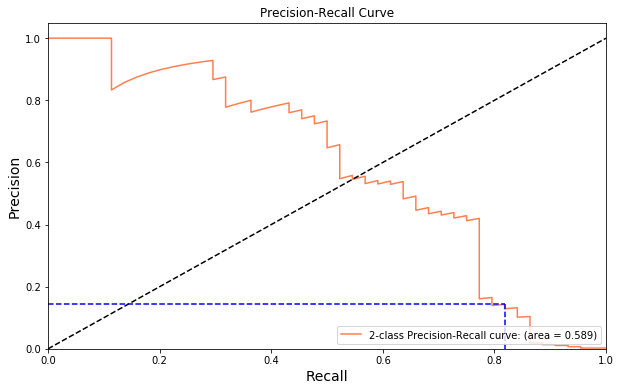

Using a threshold of 0.824 guarantees a precision of 0.143 and a recall of 0.818


In [14]:
smote_logit(df_train_x,df_train_y,1,0.8)

Logit Model Results:
LogisticRegression Area under PR-Curve is 0.530
Plot to maximize Precision with a minimum Recall of  0.8


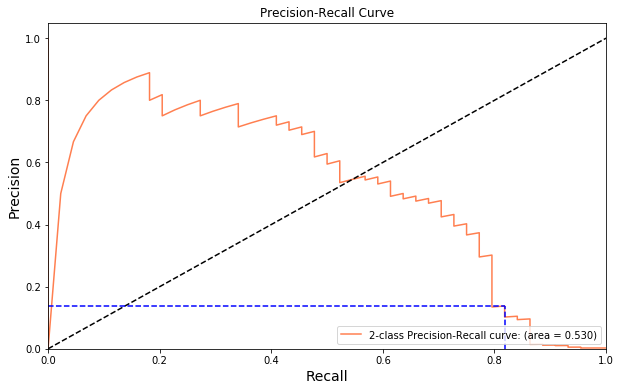

Using a threshold of 0.787 guarantees a precision of 0.138 and a recall of 0.818


In [15]:
logit(df_train_x[preds],df_train_y,1,0.8)

### 5-Fold Cross-Validation with SMOTE

In [ ]:
from sklearn.metrics import classification_report

In [16]:
def smote_logitcv(X_train, X_test, y_train, y_test,c):
    
    smt=SMOTE(ratio='minority', random_state=2, k=None, k_neighbors=5, 
          m=None, m_neighbors=10, out_step=0.5, kind='regular', svm_estimator=None, n_jobs=2)
    X_smt, y_smt=smt.fit_sample(X_train,y_train)
    X_smt=pd.DataFrame(X_smt)
    columns=X_train.columns
    X_smt.columns=columns

    logreg = LogisticRegression(penalty = 'l1', C =c, class_weight ='balanced',random_state = 2)
    logreg.fit(X_smt[preds], y_smt)

    y_pred = logreg.predict(X_test[preds])
    y_pred_proba = logreg.predict_proba(X_test[preds])[:, 1]
    
    precision, recall, thr = precision_recall_curve(y_test, y_pred_proba,pos_label =1)
    
    area_prc = average_precision_score(y_test, y_pred_proba)
    return(area_prc)

In [17]:
smt_skf = StratifiedKFold(n_splits=5,random_state=2)
area_prc_smtcv = np.empty(5)
for i, (train_index, test_index) in enumerate(smt_skf.split(df_train_x,df_train_y)):
    X_cvtrain_smt, X_cvtest_smt = df_train_x.iloc[train_index], df_train_x.iloc[test_index]
    y_cvtrain_smt, y_cvtest_smt = df_train_y.iloc[train_index], df_train_y.iloc[test_index]
    area_prc_smtcv[i]=smote_logitcv(X_cvtrain_smt, X_cvtest_smt, y_cvtrain_smt, y_cvtest_smt,1)

avg_area_prc_smt=area_prc_smtcv.mean()
print 'Mean Test Area under PRC-Curve is', avg_area_prc_smt

Mean Test Area under PRC-Curve is 0.6740143510054787


Even though the cross-validated average area under the PRC curve improved after balancing the training set. Looking at the graphs on the top, we can clearly see that the precision improved for lower values of recall but not at higher values of recall. This means the number of False Positives decreased as the number of False Negatives are more. This could be because of the noise from SMOTE over-sampling or we need to do combined sampling i.e. under and over sampling using SMOTEENN. <br>
Now, let us see if combined under-sampling of majority class and over-sampling of minority class improves precision for higher values of recall in the PRC curve.

In [18]:
from imblearn.under_sampling import EditedNearestNeighbours 

In [46]:
def smoteenn_logit(x,y,c,RecallMin=None):
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=2,stratify=y)
    
    en=EditedNearestNeighbours(ratio='majority', return_indices=False, random_state=2, 
                                size_ngh=None, n_neighbors=3, kind_sel='all', n_jobs=2)
    smt=SMOTE(ratio='minority', random_state=2, k=None, k_neighbors=5, 
          m=None, m_neighbors=10, out_step=0.5, kind='regular', svm_estimator=None, n_jobs=2)
    smteenn=SMOTEENN(ratio='minority', random_state=2, smote=None, enn=en, n_jobs=None)
    X_smteenn, y_smteenn=smteenn.fit_sample(X_train,y_train)
    X_smteenn=pd.DataFrame(X_smteenn)
    columns=x.columns
    X_smteenn.columns=columns
    
    # check classification scores of logistic regression
    logreg = LogisticRegression(penalty = 'l1', C =c, class_weight ='balanced',random_state = 2)
    logreg.fit(X_smteenn[preds], y_smteenn)

    y_pred = logreg.predict(X_test[preds])
    y_pred_proba = logreg.predict_proba(X_test[preds])[:, 1]
    area_prc = average_precision_score(y_test, y_pred_proba)
    print('Logit Model on SMOTE balanced data Results:')
    print(logreg.__class__.__name__+" Area under PR-Curve is %2.3f" % area_prc)

    precision, recall, thr = precision_recall_curve(y_test, y_pred_proba,pos_label =1)
    
    if RecallMin:
        print "Plot to maximize Precision with a minimum Recall of ",RecallMin
        ind=np.argmax(precision[recall>RecallMin])
        
        plt.figure(figsize=(10,6))
        plt.plot(recall, precision, color='coral', label='2-class Precision-Recall curve: (area = %0.3f)' % area_prc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot([0,recall[ind]], [precision[ind],precision[ind]], 'k--', color='blue')
        plt.plot([recall[ind],recall[ind]], [0,precision[ind]], 'k--', color='blue')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall', fontsize=14)
        plt.ylabel('Precision', fontsize=14)
        plt.title('Precision-Recall Curve')
        plt.legend(loc="lower right")
        plt.show()
       
        print("Using a threshold of %.3f " % thr[ind] + "guarantees a precision of %.3f " % precision[ind] +  
                  "and a recall of %.3f" % recall[ind])
    else:
        print
        print('Plot to maximize both Precision and Recall')
        area, thr = ((precision)*(recall)), thr
        idx= np.argmax(area)

        plt.figure(figsize=(10,6))
        plt.plot(recall, precision, color='coral', label='2-class Precision-Recall curve: (area = %0.3f)' % area_prc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot([0,recall[idx]], [precision[idx],precision[idx]], 'k--', color='blue')
        plt.plot([recall[idx],recall[idx]], [0,precision[idx]], 'k--', color='blue')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall', fontsize=14)
        plt.ylabel('Precision', fontsize=14)
        plt.title('Precision-Recall Curve')
        plt.legend(loc="lower right")
        plt.show()

        print("Using a threshold of %.3f " % thr[idx] + "guarantees a precision of %.3f " % precision[idx] +  
                  "and a recall of %.3f" % recall[idx])

Logit Model on SMOTE balanced data Results:
LogisticRegression Area under PR-Curve is 0.589
Plot to maximize Precision with a minimum Recall of  0.8


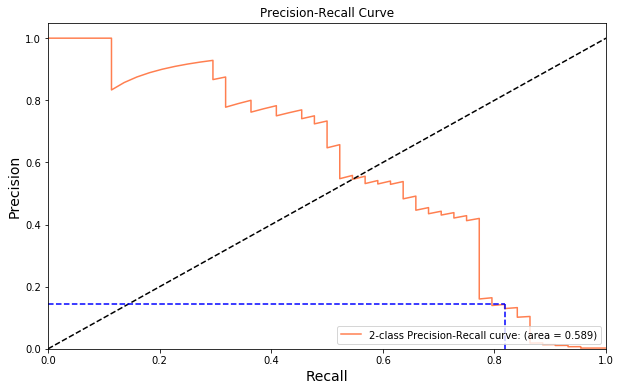

Using a threshold of 0.830 guarantees a precision of 0.143 and a recall of 0.818


In [47]:
smoteenn_logit(df_train_x,df_train_y,1,0.8)

Logit Model Results:
LogisticRegression Area under PR-Curve is 0.530
Plot to maximize Precision with a minimum Recall of  0.8


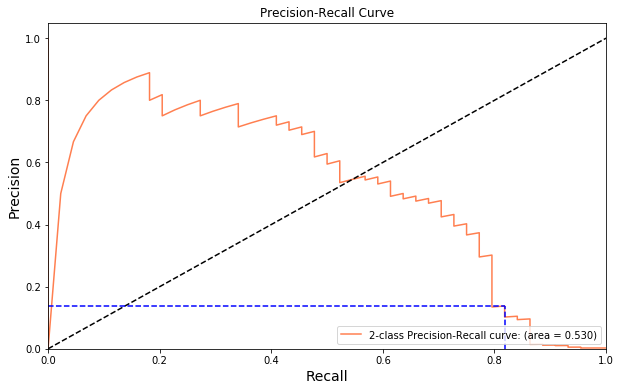

Using a threshold of 0.787 guarantees a precision of 0.138 and a recall of 0.818


In [48]:
logit(df_train_x[preds],df_train_y,1,0.8)

There seems to be not much difference between sampling through SMOTE and SMOTEENN.

### Bagging Logit Models + SMOTE

In [69]:
from sklearn.ensemble import BaggingClassifier 

In [72]:
def bag_smtlogit(x,y,num_est,c,RecallMin=None):
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=2,stratify=y)
    
    smt=SMOTE(ratio='minority', random_state=2, k=None, k_neighbors=5, 
          m=None, m_neighbors=10, out_step=0.5, kind='regular', svm_estimator=None, n_jobs=2)
    X_smt, y_smt=smt.fit_sample(X_train,y_train)
    X_smt=pd.DataFrame(X_smt)
    columns=x.columns
    X_smt.columns=columns
    

    # check classification scores of logistic regression
    est = LogisticRegression(penalty = 'l1', C =c, class_weight ='balanced',random_state = 2)
    
    logreg = BaggingClassifier(base_estimator=est, n_estimators=num_est,random_state=2)
    logreg.fit(X_train, y_train)

    y_pred = logreg.predict(X_test[preds])
    y_pred_proba = logreg.predict_proba(X_test[preds])[:, 1]
    area_prc = average_precision_score(y_test, y_pred_proba)
    print('Bagging Logit Model + SMOTE Results:')
    print(logreg.__class__.__name__+" Area under PR-Curve is %2.3f" % area_prc)

    precision, recall, thr = precision_recall_curve(y_test, y_pred_proba,pos_label =1)
    
    if RecallMin:
        print "Plot to maximize Precision with a minimum Recall of ",RecallMin
        ind=np.argmax(precision[recall>RecallMin])
        
        plt.figure(figsize=(10,6))
        plt.plot(recall, precision, color='coral', label='2-class Precision-Recall curve: (area = %0.3f)' % area_prc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot([0,recall[ind]], [precision[ind],precision[ind]], 'k--', color='blue')
        plt.plot([recall[ind],recall[ind]], [0,precision[ind]], 'k--', color='blue')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall', fontsize=14)
        plt.ylabel('Precision', fontsize=14)
        plt.title('Precision-Recall Curve')
        plt.legend(loc="lower right")
        plt.show()
       
        print("Using a threshold of %.3f " % thr[ind] + "guarantees a precision of %.3f " % precision[ind] +  
                  "and a recall of %.3f" % recall[ind])
    else:
        print
        print('Plot to maximize both Precision and Recall')
        area, thr = ((precision)*(recall)), thr
        idx= np.argmax(area)

        plt.figure(figsize=(10,6))
        plt.plot(recall, precision, color='coral', label='2-class Precision-Recall curve: (area = %0.3f)' % area_prc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot([0,recall[idx]], [precision[idx],precision[idx]], 'k--', color='blue')
        plt.plot([recall[idx],recall[idx]], [0,precision[idx]], 'k--', color='blue')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall', fontsize=14)
        plt.ylabel('Precision', fontsize=14)
        plt.title('Precision-Recall Curve')
        plt.legend(loc="lower right")
        plt.show()

        print("Using a threshold of %.3f " % thr[idx] + "guarantees a precision of %.3f " % precision[idx] +  
                  "and a recall of %.3f" % recall[idx])

Logit Model on SMOTE balanced data Results:
BaggingClassifier Area under PR-Curve is 0.690
Plot to maximize Precision with a minimum Recall of  0.8


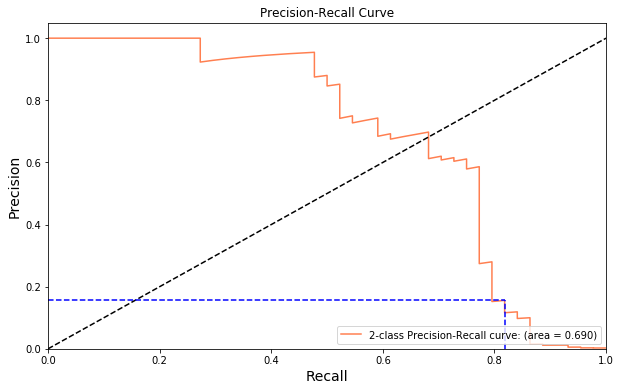

Using a threshold of 0.767 guarantees a precision of 0.156 and a recall of 0.818


In [73]:
bag_smtlogit(df_train_x[preds],df_train_y,100,1,0.8)

This plot clearly shows that using ensemble learning methods on SMOTE balanced data will improve the recall and precision of the model. As the next step, let us jump into Random Forests and Gradian Boosting Machines.